In [123]:
import csv
import sqlite3
import pandas as pd
import math
# Use svg backend for better quality
import matplotlib
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
# AUTOLAB_IGNORE_STOP

C:\Users\Anupam\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Anupam\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Anupam\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Anupam\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Anupam\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Anupam\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File

# Relational Data and Visualization [30pts]
In this problem, you will be analyzing the Twitter data we extracted using [this](https://dev.twitter.com/overview/api) api. The data consists of Twitter users (with unique handles) and their attributes (e.g., number of followers), some recent tweets posted by them with attributes (e.g., time stamp, number of retweets), and the follow relationship between the users. These are available in the three CSV files provided to you:
- users.csv - users, user attributes
- edges.csv - follow edges (directed, an edge from A to B means A follows B or B is a friend of A)
- tweets.csv - tweets posted by the users along with its attributes

## Q1. Relational Data [5pts + 6pts + 6pts]
This question will guide you through loading Twitter data into an in-memory SQLite database and running some basic queries on it.

### Q1. Task A: Load Twitter data into SQLite database [5pts]
Your first task is to use the csv and sqlite3 python packages to load the three csv files we give you as relations (or tables) into an SQLite in-memory database.

Loading the data from csv file into the database involves the following steps:
1. Identify the schema of the table (for this problem, you will only need TEXT and INTEGER attribute types)
2. Create a table with the identified schema
3. Load the contents of csv in memory
4. Insert every row of csv file as a record in the table

You can refer to [sqlite3 documentation](https://docs.python.org/2/library/sqlite3.html) and the class lecture for steps 2 and 4. For step 3, refer to the [csv documentation](https://docs.python.org/2/library/csv.html). Be sure to name your tables `users`, `edges`, and `tweets`. 

Make sure to commit (the equivalent of Ctrl+S for databases) any changes you make to the database. [This](https://www.techopedia.com/definition/16/commit) page should give you an idea about why commit is essential.

In [124]:
def load_twitter_data_sqlite3(conn, users_filepath, edges_filepath, tweets_filepath) :
    """ Load twitter data in the three files as tables into an in-memory SQLite database
    Input:
        conn (sqlite3.Connection) : Connection object corresponding to the database; used to perform SQL commands.
        users_filepath (str) : absolute/relative path to users.csv file
        edges_filepath (str) : absolute/relative path to edges.csv file
        tweets_filepath (str) : absolute/relative path to tweets.csv file
    Output:
        None
    """
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE users (
        name TEXT,
        screen_name TEXT,
        location TEXT,
        created_at TEXT,
        friends_count INTEGER,
        followers_count INTEGER,
        statuses_count INTEGER,
        favourites_count INTEGER);
        """)
    cursor.execute("""CREATE TABLE edges (
        screen_name TEXT,
        friend TEXT);
        """)
    cursor.execute("""CREATE TABLE tweets (
        screen_name TEXT,
        created_at TEXT,
        retweet_count INTEGER,
        favorite_count INTEGER,
        text TEXT);
        """)
    with open(users_filepath,'r',encoding="utf8") as file:
            data = csv.DictReader(file) 
            to_db =[(str(d['name']),str(d['screen_name']),str(d['location']),str(d['created_at']),int(d['friends_count']),int(d['followers_count']),int(d['statuses_count']),int(d['favourites_count'])) for d in data]
    cursor.executemany("""INSERT INTO users (name,screen_name,location,created_at,friends_count,followers_count,statuses_count ,favourites_count) VALUES (?,?,?,?,?,?,?,?);""",to_db)
    
    with open(edges_filepath,'r',encoding="utf8") as file:
            data = csv.DictReader(file) 
            to_db =[(str(d['screen_name']),str(d['friend'])) for d in data]
    cursor.executemany("INSERT INTO edges (screen_name, friend) VALUES (?, ?);", to_db)
        
    with open(tweets_filepath,'r',encoding="utf8") as file:
            data = csv.DictReader(file) 
            to_db =[(str(d['screen_name']),str(d['created_at']),int(d['retweet_count']),int(d['favorite_count']),str(d['text'])) for d in data]
    cursor.executemany("INSERT INTO tweets (screen_name,created_at,retweet_count,favorite_count, text) VALUES (?,?,?,?,?);", to_db)
    return None
    


Your function will be called as in the cell below. The cell also contains some test code to display all tables in the database. You may want to write you own tests for the individual tables to verify that the data has been loaded properly. (e.g., number of tuples in each table)

In [125]:
# AUTOLAB_IGNORE_START
# connect to an in memory database
conn = sqlite3.connect(":memory:")
conn.text_factory = str
# call to your function
load_twitter_data_sqlite3(conn, 'users.csv', 'edges.csv', 'tweets.csv')
# make sure to change the path to csv files appropriately
cursor = conn.cursor()
# prints all tables in the database
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';"):
    print (row)
# for row in cursor.execute("SELECT * FROM tweets WHERE screen_name = 'table';"):
#     print(row)
# AUTOLAB_IGNORE_STOP

('users',)
('edges',)
('tweets',)


### Q1. Task B: Trending tweets in a topic [6pts]
Twitter is regarded as an invaluable source of valuable information. Hence, one of the favorite tasks of data miners is the analyse the trending tweets in a given topic.

This task requires you to retrieve the top N most trending tweets (in descending order of trending_score) about a given topic (which is a list of keywords). The following information may be useful:

- A tweet is said to be about a given topic if it contains any of the given topical phrases/keywords.
- We will use the following simple trending_score: retweet_count + favorite_count. Tweets with higher trending_score must be ranked before the ones with lower trending_score.
- Your result must contain unique tweets. If a tweet text occurs multiple times, display it only once with its highest trending_score.
- Break ties by sorting the tweets in alphabetical order.

The output schema should be as follows:

|tweet (TEXT)| trending_score (INTEGER) |
| :--- |:--- |
| | |

In [126]:
def trending_tweets(cursor, topical_phrases=['Hillary', 'Clinton'], N=5):
    """ Retrieves the top N trending tweets containing one or more of the given topical phrases.
    Input:
        cursor (sqlite3.Cursor): Cursor object to query the database.
        topical_phrases (list of strings): A list of keywords identifying a topic.
        N: Number of trending tweets to retrieve
    Output:
        results (sqlite3.Cursor): Cursor object which can be used to iterate over the retrieved records/tuples.
    """
    words =[]
    like_statement=""   
    for i in topical_phrases:
        words.append("%"+i+"%")
    results = cursor.execute("""select
                                text as tweet,
                                retweet_count+favorite_count as trending_score 
                                from tweets 
                                where text like ? or text like ?
                                order by retweet_count+favorite_count desc limit ?;""",(words[0],words[1],N))
    return results

The default inputs to the function will retrieve 5 trending tweets about topic Hillary Clinton. You can view the output of your query using the following code.

In [127]:
# AUTOLAB_IGNORE_START
results = trending_tweets(conn.cursor())
for row in results:
    print(row)
# AUTOLAB_IGNORE_STOP

("Hillary just gave a disastrous news conference on the tarmac to make up for poor performance last night. She's being decimated by the media!", 37903)
('"A rough night for Hillary Clinton"  ABC News.', 34418)
('Hillary Clinton answered email questions differently last night than she has in the past. She is totally confused. Unfit to serve as #POTUS.', 32843)
("'Donald Trump leads Hillary Clinton by 19 points among military, veteran voters: poll' #AmericaFirst #MAGA\nhttps://t.co/5FmxGtLkwt", 29538)
("It wasn't Matt Lauer that hurt Hillary last night. It was her very dumb answer about emails &amp; the veteran who said she should be in jail.", 24414)


### Q1. Task C: Tweet recommendation [6pts]
How does Twitter go about populating the feed for a user? While Twitter may use a comple models to do this, in this task, we will use a Simple Tweet Recommender (STR), which recommends a user's tweets to all users who follow him/her (without checking for possible duplicates; i.e., STR may recommend the same tweet twice if two of a user's friends have posted it).

In this task, you will write a query to determine the number of tweets recommended to each user. Use only the snapshot of edges and tweets we have provided to you to do the recommendation. Report the results on the users present in the users table. (Hint: The number of records in your output should match that in the "users" table.) The order of results does not matter.

The output schema should be:

|screen_name (TEXT)| num_tweets (INTEGER) |
| :--- |:--- |
| | | |


In [179]:
def num_tweets_in_feed(cursor):
    """ Retrieves the number of tweets STR recommends to each Twitter user.
    Input:
        cursor (sqlite3.Cursor): Cursor object to query the database.
    Output:
        results (sqlite3.Cursor): Cursor object which can be used to iterate over the retrieved records/tuples.
    """         
    query = """ select users.screen_name ,Ifnull(b.num_tweets,0)
                from users
                left join
                (select edges.screen_name as name ,count(tweets.text) as num_tweets
                from tweets join edges
                where tweets.screen_name = edges.friend
                group by (edges.screen_name))b
                on users.screen_name =b.name

            """

    return cursor.execute(query)

# AUTOLAB_IGNORE_START
results = num_tweets_in_feed(conn.cursor())
i = 0
for row in results:
    #print(row)
#     if row[1]==0:
#         print(row)
# #     if i>20:
# #         break
     i += 1
print(i)
# AUTOLAB_IGNORE_STOP

12403


## Q2. Visualization [2pts + 7pts + 4pts]
In this question, you will load all data into pandas dataframes and analyse (and visualize!) some interesting trends using [matplotlib](http://matplotlib.org) python package.

### Q2. Task A: Load Twitter data using pandas [2pts]
Fill in the following method stub and return the data frames for users, edges and tweets.

Pandas will treat missing values as NaNs by default. However, for this assignment, you should treat missing values (i.e., empty strings in the csv files) as empty strings.

In [64]:
def load_twitter_data_pandas(users_filepath, edges_filepath, tweets_filepath):
    """ Loads the Twitter data from the csv files into Pandas dataframes
    Input:
        users_filepath (str) : absolute/relative path to users.csv file
        edges_filepath (str) : absolute/relative path to edges.csv file
        tweets_filepath (str) : absolute/relative path to tweets.csv file
    Output:
        (pd.DataFrame, pd.DataFrame, pd.DataFrame) : A tuple of three dataframes, the first one for users,
                                                    the second for edges and the third for tweets.
    """
    users_df  = pd.read_csv(users_filepath)
    users_df = users_df.fillna('')
    edges_df  = pd.read_csv(edges_filepath)
    edges_df = edges_df.fillna('')
    tweets_df = pd.read_csv(tweets_filepath)
    tweets_df = tweets_df.fillna('')
    return (users_df,edges_df,tweets_df)


You can test your function using the following code.

In [65]:
# AUTOLAB_IGNORE_START
(users_df, edges_df, tweets_df) = load_twitter_data_pandas('users.csv', 'edges.csv', 'tweets.csv')
# make sure to change the path to csv files appropriately
print (users_df.head())
print (edges_df.head())
print (tweets_df.head())
# AUTOLAB_IGNORE_STOP

                 name      screen_name      location  \
0     Donald J. Trump  realDonaldTrump  New York, NY   
1  Trump Organization            Trump  New York, NY   
2          Trump Golf        TrumpGolf                 
3       Tiffany Trump    TiffanyATrump                 
4      Laura Ingraham    IngrahamAngle            DC   

                       created_at  friends_count  followers_count  \
0  Wed Mar 18 13:46:38 +0000 2009             42         11397769   
1  Wed Apr 13 16:51:54 +0000 2016             35             9954   
2  Mon Feb 03 13:46:03 +0000 2014            200             8797   
3  Tue Feb 01 20:59:30 +0000 2011             79            63138   
4  Thu Jun 25 21:03:25 +0000 2009            289           851876   

   statuses_count  favourites_count  
0           33136                38  
1              43               125  
2             758               251  
3             573                28  
4           26523                71  
       screen_name  

### Q2. Task B: Correlation [4pts + 3pts]
Statisticians and data analysts usually like to study about correlation between different observed variables. This helps uncover interesting patterns in the data such as causal relationships (e.g., snow on the road leads to increase in number of accidents). Correlation studies are important for multiple reasons:
- While [correlation does not imply causation](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation), a lack of correlation implies a lack of causation. This can be used to rule out many causal relationships.
- Correlation helps with prediction. The more closely related two variables are, the easier it is to predict one from the other.

In this task, we ask you to plot the friends_count (on y-axis) vs the followers_count (on x-axis) using the matplotlib package. [Here](http://matplotlib.org/examples/shapes_and_collections/scatter_demo.html) is an example to get started with scatter plots.

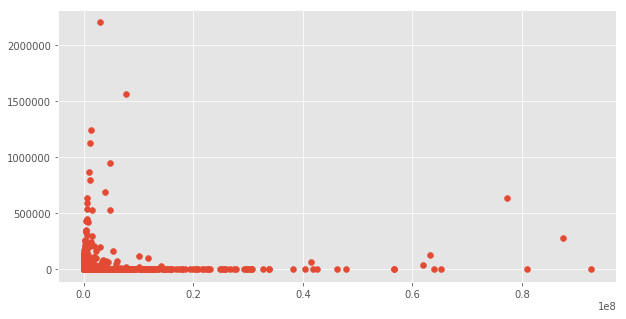

In [73]:
def plot_friends_vs_followers(users_df):
    """ Plots the friends_count (on y-axis) against the followers_count (on x-axis).
    Input:
        users_df (pd.DataFrame) : Dataframe containing Twitter user attributes,
                                    as returned by load_twitter_data_pandas()
    Output:
        (matplotlib.collections.PathCollection) : The object returned by the scatter plot function
    """
    x=users_df['followers_count']
    y=users_df['friends_count']
    return  plt.scatter(x,y)

# AUTOLAB_IGNORE_START
p = plot_friends_vs_followers(users_df)
plt.show()
# AUTOLAB_IGNORE_STOP

Do you see a correlation between these two variables from your scatter plot? Let's measure this quantitatively using the [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). 

For a set of observations $(X,Y) = [(x_1,y_1), (x_2,y_2), ... , (x_n,y_n)]$, the Pearson's correlation coefficient is a measure of the linear dependence between two variables $X$ and $Y$, giving a value between +1 and −1 inclusive, where 1 is total positive correlation, 0 is no correlation, and −1 is total negative correlation.

$r=r_{xy}={\frac {n\sum x_{i}y_{i}-\sum x_{i}\sum y_{i}}{{\sqrt {n\sum x_{i}^{2}-(\sum x_{i})^{2}}}~{\sqrt {n\sum y_{i}^{2}-(\sum y_{i})^{2}}}}}$

Now, fill in the following function to compute the Pearson's correlation coefficient between friends_count and followers_count.

In [116]:
def correlation_coefficient(users_df):
    """ Plots the friends_count (on y-axis) against the followers_count (on x-axis).
    Input:
        users_df (pd.DataFrame) : Dataframe containing Twitter user attributes,
                                    as returned by load_twitter_data_pandas()
    Output:
        (double) : correlation coefficient between friends_count and followers_count
    """
    import numpy
    x=users_df['followers_count']
    y=users_df['friends_count']
    x = numpy.array(x, dtype=numpy.float64)
    y = numpy.array(y, dtype=numpy.float64)
    nr = ((x-x.mean())*(y-y.mean())).sum()
    dr1 = math.sqrt(((x-x.mean())**2).sum())
    dr2= math.sqrt(((y-y.mean())**2).sum())
#     xy = x*y
#     xsq = x**2
#     ysq =y**2
#     n=len(users_df)
#     nr = (n*(xy).sum())-(x.sum()*y.sum())    
#     dr1 = math.sqrt(n*xsq.sum()-((x.sum())**2))
#     dr2 = math.sqrt(n*ysq.sum()-((y.sum())**2))
    return nr/(dr1*dr2)
    
# AUTOLAB_IGNORE_START
print (correlation_coefficient(users_df))
# AUTOLAB_IGNORE_STOP

0.0930864051648


### Q2. Task C: Degree distribution [4pts]
If you are not familiar with graph theory and/or graph mining, skip the first paragraph.

As you're familiar with graphs, you might know that the degree of a node is the number of connections it has to other nodes. A common statistic to look out for in the case of real world graphs is the degree distribution. Literature says degrees of nodes in real world graphs follow a [power law distribution](https://en.wikipedia.org/wiki/Power_law). The implication is that a scatter plot of num_users versus k (as we will define below) yields an almost straight line. In this task, we shall verify whether the given crawl of Twitter network satisfies this property.

Let us call the number of friends a Twitter user has as his/her degree. The degree distribution is a histogram of the number of friends. Your task is to visualize this histogram. Use the default number of bins.

[   2.    6.    2.    5.    4.    4.    3.    1.    4.  148.] [   2.    11.8   21.6   31.4   41.2   51.    60.8   70.6   80.4   90.2
  100. ] <a list of 10 Patch objects>


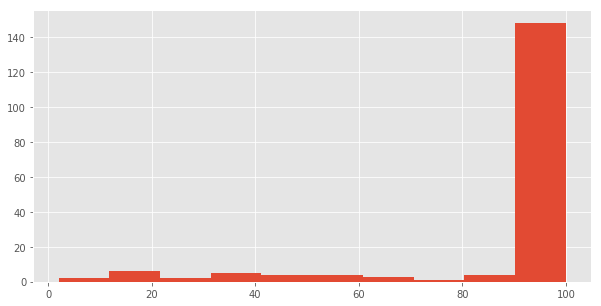

In [175]:
def degree_distribution(edges_df):
    """ Plots the distribution of .
    Input:
        edges_df (pd.DataFrame) : Dataframe containing Twitter edges,
                        as returned by load_twitter_data_pandas()
    Output:
        (array, array, list of Patch objects) : Tuple of the values of the histogram bins, 
                        the edges of the bins and the silent list of individual patches used to create the histogram.
    """
    num_of_frnds =[]
    groups = list(edges_df.groupby(edges_df['screen_name']))
    groups =edges_df.groupby('screen_name').count()
    num_of_frnds = list(groups["friend"])
    n, bins, patches  = plt.hist(num_of_frnds)
    return (n, bins, patches)

# AUTOLAB_IGNORE_START
degree_distribution(edges_df)
# AUTOLAB_IGNORE_STOP

Do you notice any surprising/unexpected pattern? What can you say about the way in which the Twitter data was collected?

In [ ]:
(users_df, edges_df, tweets_df) = load_twitter_data_pandas('users.csv', 'edges.csv', 'tweets.csv')
degree_distribution(edges_df)